In [1]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

def read_csv(root_path):
    with open(root_path + 'driving_log.csv', 'r') as f:
        reader = csv.reader(f)
        for line in reader:
            yield line

def make_local_path(path, local_root):
    basename = path.split('/')[-1]
    return local_root + 'IMG/' + basename

def load_image(local_path):
    return cv2.imread(local_path)

def extract_images(csv_line, local_root):
    paths = csv_line[0:3]
    return [load_image(make_local_path(p, local_root)) for p in paths]

def extract_measurements(csv_line):
    return float(csv_line[3])

In [24]:
images = []
measurements = []

forward_img = './data/forward/'
reverse_img = './data/reverse/'

print("Reading forward images...\n")
for line in read_csv(forward_img):
    images.append(extract_images(line, forward_img)[0])
    measurements.append(extract_measurements(line))

print("Reading reverse images...\n")
for line in read_csv(reverse_img):
    images.append(extract_images(line, reverse_img)[0])
    measurements.append(extract_measurements(line))

X_train = np.array(images, np.float32)
y_train = np.array(measurements, np.float32)

print("Training set shape: ", X_train.shape)
print("Labels shape: ", y_train.shape)


Reading forward images...

Reading reverse images...

Training set shape:  (15911, 160, 320, 3)
Labels shape:  (15911,)


In [ ]:
n_samples = y_train.shape[0]
plt.plot(range(n_samples), y_train)

In [47]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Convolution2D, MaxPooling2D, Lambda

image_shape = X_train.shape[1:]
normalize = lambda x: (x - 127.0) / 127.0

model = Sequential()
model.add(Lambda(normalize, input_shape=image_shape))
model.add(Convolution2D(6, kernel_size=(5, 5), padding='valid', activation='relu', input_shape=image_shape))
model.add(MaxPooling2D(pool_size=2, padding='valid'))
model.add(Convolution2D(16, kernel_size=(5, 5), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2, padding='valid'))

model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, verbose=2, batch_size=256, epochs=15)

model.save('model.h5')

Train on 12728 samples, validate on 3183 samples
Epoch 1/15
31s - loss: 2.5081 - val_loss: 0.0585
Epoch 2/15
31s - loss: 0.0539 - val_loss: 0.0510
Epoch 3/15
31s - loss: 0.0510 - val_loss: 0.0490
Epoch 4/15
31s - loss: 0.0503 - val_loss: 0.0518
Epoch 5/15
31s - loss: 0.0490 - val_loss: 0.0491
Epoch 6/15
31s - loss: 0.0481 - val_loss: 0.0503
Epoch 7/15
31s - loss: 0.0473 - val_loss: 0.0481
Epoch 8/15
31s - loss: 0.0466 - val_loss: 0.0483
Epoch 9/15
31s - loss: 0.0453 - val_loss: 0.0484
Epoch 10/15
31s - loss: 0.0449 - val_loss: 0.0477
Epoch 11/15
31s - loss: 0.0440 - val_loss: 0.0489
Epoch 12/15
31s - loss: 0.0430 - val_loss: 0.0491
Epoch 13/15
31s - loss: 0.0424 - val_loss: 0.0483
Epoch 14/15
31s - loss: 0.0409 - val_loss: 0.0535
Epoch 15/15
31s - loss: 0.0398 - val_loss: 0.0485


(0, 0.2)

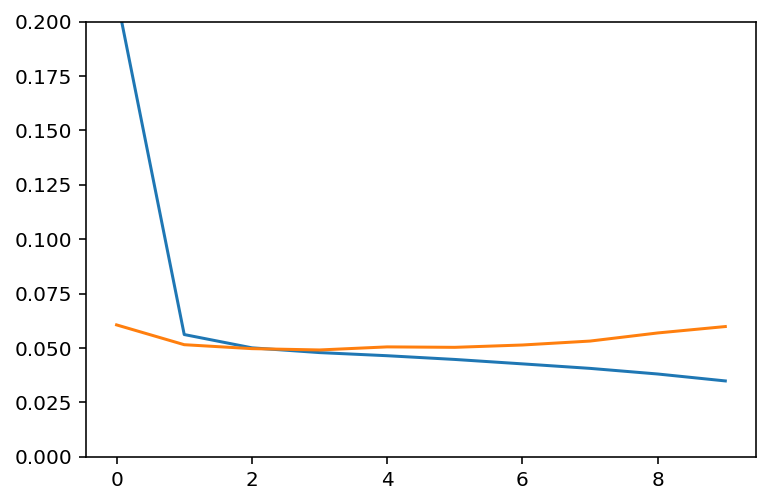

In [38]:
epochs = history.epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.ylim(0, 0.2)